# Baseline CNN Model

**Purpose:**  
This notebook builds and evaluates a **baseline Convolutional Neural Network (CNN)** for weed species classification using the *Winter Cereals Weeds Image Dataset*.  
It follows the exploratory analysis conducted in `01_eda.ipynb` and represents the first modeling step.

##Imports

Load all libraries required to build, train, and evaluate the baseline CNN model.

**Libraries:**
- `numpy` — numerical operations and array manipulation.  
- `pandas` — handling tabular data (e.g., storing and exporting training history).  
- `matplotlib.pyplot` — plotting training curves and visualizations.  
- `pathlib` — convenient handling of filesystem paths.  
- `random` — simple random sampling (e.g., selecting random images).  
- `tensorflow` and `keras` — main deep learning framework for defining, training, and evaluating the CNN.  
  - `layers` — building blocks such as convolution, pooling, dropout, and dense layers.  
  - `models` — constructing the CNN model (`Sequential` or functional API).  
- `sklearn.metrics` — evaluation tools:  
  - `confusion_matrix` and `ConfusionMatrixDisplay` for detailed error analysis.  
  - `classification_report` for precision, recall, F1-score, and accuracy metrics.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Dataset Path Setup
 
Define the root path of the weed image dataset and verify that the notebook points to the correct location.

In [21]:
data_dir = pathlib.Path("../data/raw/Winter_cereals_weeds_image_dataset")
print(data_dir.resolve())

C:\Users\tim-b\Desktop\Projekte\Weed_identification\data\raw\Winter_cereals_weeds_image_dataset


##Reproducibility and Parameters

Set random seeds for reproducibility and define key parameters for image preprocessing and dataset creation.

**Details:**  
- `seed = 42` ensures that random operations (e.g., dataset splitting, shuffling, weight initialization) produce the same results across runs.  
  - `np.random.seed(seed)` fixes randomness in NumPy.  
  - `tf.random.set_seed(seed)` fixes randomness in TensorFlow.  
  - `random.seed(seed)` fixes randomness in Python’s built-in random module.  

- Image parameters:  
  - `img_height = 224` and `img_width = 224` resize all images to a fixed resolution, matching common CNN input sizes.  
  - `batch_size = 32` specifies how many images are processed per step during training.  
  - `validation_split = 0.2` reserves 20% of the dataset for validation. 

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

img_height = 224
img_width = 224
batch_size = 32
validation_split = 0.2

## Create Training and Validation Datasets
  
Load images from the dataset directory and split them into training and validation sets.

In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 10810 files belonging to 7 classes.
Using 8648 files for training.
Found 10810 files belonging to 7 classes.
Using 2162 files for validation.


## Inspect Class Names

Retrieve and display the list of class labels inferred from the dataset directory structure.

In [24]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Avena_sterilis', 'Convolvulus_arvensis', 'Fumaria_officinalis', 'Lolium_multiflorum', 'Papaver_rhoeas', 'Veronica_persica', 'Vicia_sativa']


## Optimize Dataset Pipeline
  
Improve input pipeline performance by caching, shuffling, and prefetching batches of images.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Define and Compile Baseline CNN

Construct a baseline Convolutional Neural Network (CNN) architecture, compile it, and display the model summary.

In [26]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\tim-b\Desktop\Projekte\Weed_identification\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Define Callbacks

Set up callbacks to automatically manage training, prevent overfitting, and save the best-performing model.

In [27]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="../results/models/baseline_best.keras",
        monitor="val_loss", save_best_only=True
    )
]


## Train the Baseline CNN
 
Train the CNN model on the training dataset while monitoring performance on the validation dataset.

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 236s 543ms/step - accuracy: 0.5611 - loss: 1.1915 - val_accuracy: 0.7447 - val_loss: 0.7455
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 127s 467ms/step - accuracy: 0.7731 - loss: 0.6470 - val_accuracy: 0.7525 - val_loss: 0.6862
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 119s 441ms/step - accuracy: 0.8536 - loss: 0.4288 - val_accuracy: 0.8270 - val_loss: 0.5002
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 135s 499ms/step - accuracy: 0.9123 - loss: 0.2569 - val_accuracy: 0.8474 - val_loss: 0.4581
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 127s 470ms/step - accuracy: 0.9410 - loss: 0.1732 - val_accuracy: 0.8441 - val_loss: 0.4875
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 148s 546ms/step - accuracy: 0.9446 - loss: 0.1632 - val_accuracy: 0.8464 - val_loss: 0.5671
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 134s 496ms/step - accuracy: 0.9681 - loss: 0.0910 - val_accuracy: 0.8571 - val_loss: 0.5827
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 124s 459ms/step - accuracy: 0.9588 -

## Plot Training History

Visualize the training process by plotting loss and accuracy curves for both training and validation sets.

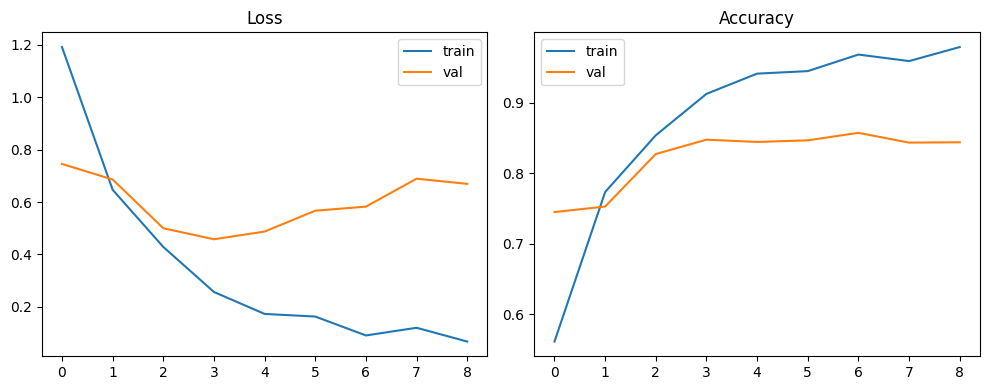

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("../results/figures/plot_loss_accuracy.png", dpi = 300)
plt.show()


**Conclusion:**  
- The baseline CNN can learn strong patterns from the training data.  
- Generalization to unseen data is limited, with performance stabilizing around **85% validation accuracy**.  
- Future steps (data augmentation, class weights, transfer learning) are needed to reduce overfitting and improve validation performance.

## Confusion Matrix and Classification Report

Evaluate the trained model on the validation dataset using a confusion matrix and classification metrics (precision, recall, F1-score).

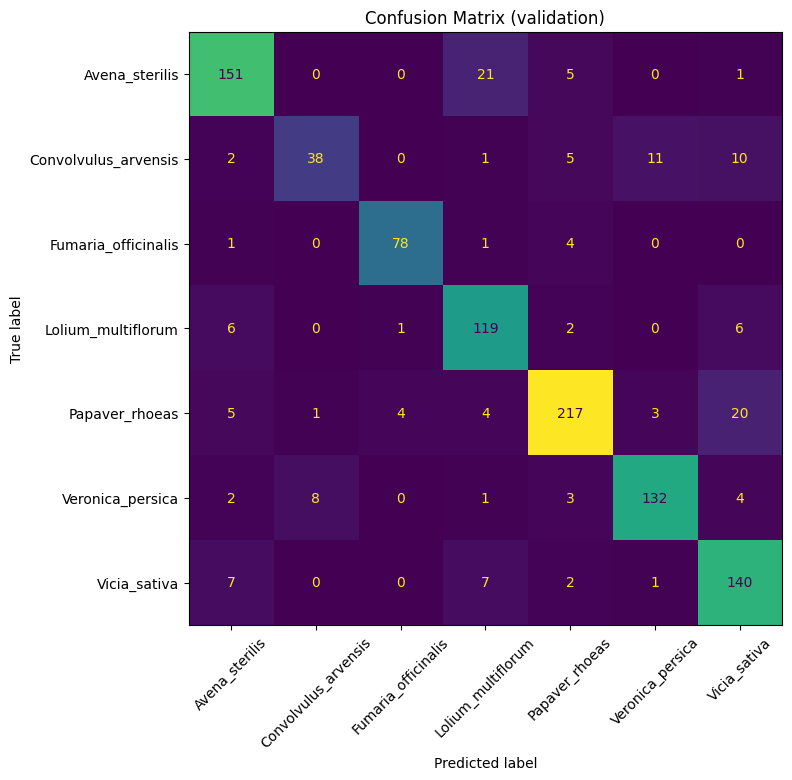

                      precision    recall  f1-score   support

      Avena_sterilis       0.87      0.85      0.86       178
Convolvulus_arvensis       0.81      0.57      0.67        67
 Fumaria_officinalis       0.94      0.93      0.93        84
  Lolium_multiflorum       0.77      0.89      0.83       134
      Papaver_rhoeas       0.91      0.85      0.88       254
    Veronica_persica       0.90      0.88      0.89       150
        Vicia_sativa       0.77      0.89      0.83       157

            accuracy                           0.85      1024
           macro avg       0.85      0.84      0.84      1024
        weighted avg       0.86      0.85      0.85      1024



In [32]:
# Klassenliste beibehalten
idx_to_class = {i:c for i,c in enumerate(class_names)}

# Ein kleines, fixes Val-Dataset für Vorhersagen materialisieren
val_images, val_labels = next(iter(val_ds.unbatch().batch(1024)))
pred_probs = model.predict(val_images, verbose=0)
y_pred = pred_probs.argmax(axis=1)
y_true = val_labels.numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (validation)")
plt.tight_layout()
plt.savefig("../results/figures/confusion_matrix.png", dpi = 300)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


**Conclusion:**  
- The model handles large, distinct classes very well (e.g., *Papaver_rhoeas*).  
- Some visually similar species (especially grass-like weeds such as *Avena_sterilis* vs. *Lolium_multiflorum*) are harder to distinguish.  
- The weakest class (*Convolvulus_arvensis*) is underrepresented in the dataset and could benefit from **data augmentation** or **class weighting** during training.

## Save Training History
  
Store the recorded training and validation metrics for reproducibility and future analysis.

In [34]:
hist_df = pd.DataFrame(history.history)

# Als CSV speichern
hist_df.to_csv("../results/logs/baseline_history.csv", index=False)

print("Training history saved to results/logs/baseline_history.csv")

Training history saved to results/logs/baseline_history.csv
